# Clase 8 - Modos empíricos con Autoencoder

**2do Cuatrimestre 2020**

**DF - FCEyN - UBA**

Al igual que en la clase pasada, en este Notebook vamos a trabajar con datos experimentales correspondientes a una película del aparato fonador de un ave. En este sistema una membrana oscila debedio a la interacción con un flujo de aire (mismo fenómeno que sucede, por ejemplo, en nuestras cuerdas vocales). 

Aquí la película en cuestión:

Link clase 8:
https://drive.google.com/file/d/1XH-U39-puZkBUiGUGKZacwnlLFU0oW0P/view?usp=sharing 
Link Datos:
https://drive.google.com/file/d/1iakLj0IV02bDFcJklZdSBrM9Ck2Fe2nt/view?usp=sharing 

In [ ]:
from IPython.display import Image
Image(url='http://materias.df.uba.ar/sdeiaaamdda2020c2/files/2012/07/membranagif.gif')

En los primero 2 puntos, vamos a repetir el proprocesamiento realizado en el Notebook anterior.

## 1. Carpeta de Trabajo y Lectura de Archivos

Primero, vamos a montarnos sobre el directorio de google Drive. Esto nos permitira leer y guardar archivos en nuestro Drive. Generamos la dirección `root_dir` (un string) que apunta a la carpeta de trabajo. Noten que al ejecutar el comando `mount`, google nos pedirá una contraseña la cual obtendremos mediante el link que aparece.

**Nota:** Recuerden que primero deben crear en su drive la carpeta.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

# Aca deben apuntar a la carpeta de su drive donde guardaron los datos
root_dir = "/content/gdrive/MyDrive/curso_gabo/GIF/"

Mounted at /content/gdrive


Para obetner la lista de los archivos que hay en la carpeta, vamos a utilizar la librería glob. 

In [ ]:
import glob

lista=[]
lista=glob.glob(root_dir+'*.jpg')
lista.sort()

print(len(lista))
print(lista[0])

95
/content/gdrive/MyDrive/curso_gabo/GIF/Copy of 00094small.jpg


Como verán, los archivos constan de 95 frames (imagenes) de la película. Para leer estas imágenes vamos a utilizar la función `load_img` de la librería `Keras`.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

x=[]
for file in lista:    
    img = image.load_img(file, color_mode="grayscale")
    x.append(image.img_to_array(img))

x = np.array(x)

print(x.shape)

(95, 167, 120, 1)


In [ ]:
x[0].shape

(167, 120, 1)

## 2. Adecuamos los datos

Primero vamos a adecuar las imágenes con las que vamos a trabajar, es decir vamos a llevarlas a una forma adecauda para poder aplicarles el algortimo de reduccion de dimensionalidad.

In [ ]:
# Construyo tensor X de mxhxb con n = # de frames, h=altura, b=base.
X = x[:,:,:,0]

# Normalizamos: llevamos de [0,255] a [0,1]
X = X.astype('float32')/255

# Restamos la imagen Media
X_medio = np.mean(X)
X = X-X_medio

In [ ]:
X.shape

(95, 167, 120)

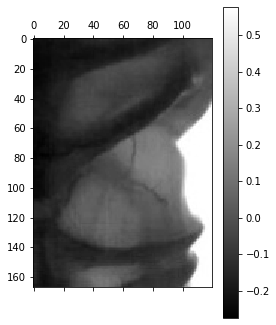

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

# Graficamos un framo como ejemplo
numero = 55
plt.matshow(X[numero],cmap='gray')
plt.colorbar()
plt.show()

Por ultimo, vamos "aplastar" el tensor que contiene las 95 imágenes. Es decir que vamos a llevarlo a una forma $(n,m)$ siendo $n = altura \times base$ y siendo $ m = \# \  frames$ .

In [ ]:
# Tomamos las dimensiones de X
dims = np.shape(X)

# Construyo matriz Y de nxm con n = altura x base, m = num de frames
Y = np.transpose(np.reshape(X,(dims[0],dims[1]*dims[2])))
Y = Y.T
print('Shape de la matrix original',np.shape(X))
print('Shape de la matrix aplanada',np.shape(Y))
#167*120=20,040

Shape de la matrix original (95, 167, 120)
Shape de la matrix aplanada (95, 20040)


## 3. Modos con Autoencoder

En lugar de utilizar SVD para encontrar modos empiricos de la película, esta vez vamos a utilizar una red neuronal en una arquitectura de **autoencoder** para realizar la reducción dimensional.

A diferencia de las redes que vinimos trabajando hasta ahora, un autoencoder no busca asociar a cada instancia un valor categórico o numérico, no hay un *target*. Este tipo de algoritmos se denominan de Aprendizaje no supervisado. En este caso, la red se entrena para comprimir la representación de las instancia de entrada de la manera mas eficiente posible: intenta reproducir en la salida los mismo valores que hay a su entrada. Es por esto que el numero de neuronas en la ultima capa debe ser igual al numero de neuronas que hay a la entrada `numero_pixeles`.

La arquitectura de este tipo de redes suele ser simétricam llamando encdoer a la primer parte (todo lo que esta antes del cuello de botella, el `latent space`) y decoder a la segunda parte.



In [ ]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation

numero_pixeles = Y.shape[1]
NUM_MODOS = 3

# building a linear stack of layers with the sequential model
model = Sequential()

# Encoder: comprimimos la representación achicando el numero de neuronas
model.add(Dense(64, input_shape=(numero_pixeles,)))                        
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(NUM_MODOS, activation='linear')) # Latent Space: Punto máximo de la compresión

# Decoder: llevamos nuevamente al mismo tamaño que la entrada
model.add(Dense(16, activation='relu'))                        
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(units=numero_pixeles, activation='linear'))

In [ ]:
model.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

In [ ]:
model.summary()  # y.shape[1]*64+64=1282624 ,  y.shape[1] es el numero de pixeles total de 1 frame

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1282624   
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2

Como dijimos, nuestro objetivo será reproducir la entrada, por lo tanto a la hora de entrenar el modelo debemos pasarle como salida el mismo dataset que a la entrada:

In [ ]:
# training the model and saving metrics in history
history = model.fit(Y, Y,
          batch_size=16, 
          epochs=500,
          validation_split=0.1, # no le pone xtest, le pone esto
          verbose=1)

Epoch 1/500
6/6 [==============================] - 0s 29ms/step - loss: 0.0468 - mean_absolute_error: 0.1542 - val_loss: 0.0279 - val_mean_absolute_error: 0.1201
Epoch 2/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0156 - mean_absolute_error: 0.0866 - val_loss: 0.0076 - val_mean_absolute_error: 0.0661
Epoch 3/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_absolute_error: 0.0645 - val_loss: 0.0057 - val_mean_absolute_error: 0.0536
Epoch 4/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_absolute_error: 0.0501 - val_loss: 0.0046 - val_mean_absolute_error: 0.0460
Epoch 5/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_absolute_error: 0.0457 - val_loss: 0.0043 - val_mean_absolute_error: 0.0431
Epoch 6/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_absolute_error: 0.0436 - val_loss: 0.0041 - val_mean_absolute_error: 0.0409
Epoch 7/500
6/6 [================

(0.0, 0.04)

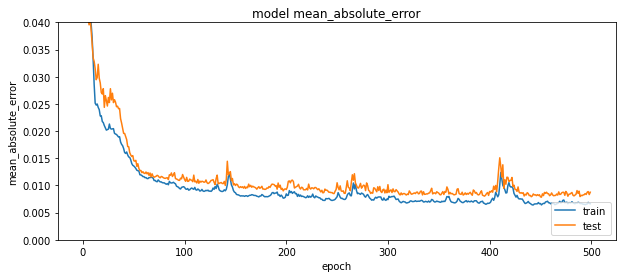

In [ ]:
fig = plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mean_absolute_error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.ylim(0,0.04)

Para poder acceder al `Latent Space` (la capa con la menor cantidad de neuronas), vamos a definir una función:

In [ ]:
from keras import backend as K
get_latent_layer_output = K.function([model.layers[0].input],[model.layers[3].output])


Ahora sí, veamos como queda representado el dataset en el `Latent Space`.

In [ ]:
layer_output = get_latent_layer_output ([Y])[:][0]
print(layer_output.shape)

(95, 3)


Noten que ahora tenemos una cantidad `NUM_MODOS` por cada instancia (por cada frame).

## 4. Evolucion Temporal de los modos

Exploremos como evolucionan temporalmente los primeros modos empíricos. Tengo la evoluncion de los modos fijandome el output del latent space para caga ejemplo de los 95 frames.

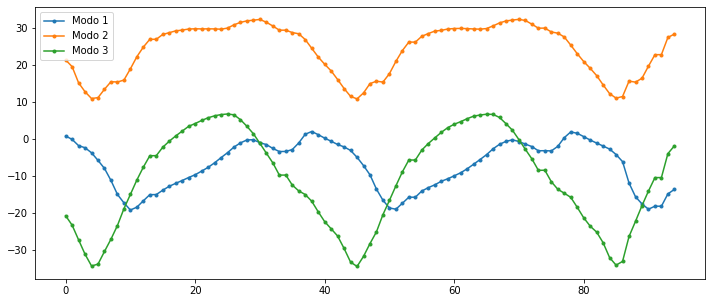

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,1,1)
plt.plot(layer_output[:,0],'.-',label='Modo 1')
plt.plot(layer_output[:,1],'.-',label='Modo 2')
plt.plot(layer_output[:,2],'.-',label='Modo 3')
plt.legend()

Text(0.5, 0, 'Modo 3')

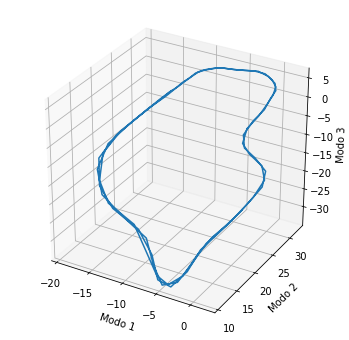

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
#ax = fig.add_subplot(1, 1, 1)

ax = fig.gca(projection='3d')
ax.plot(layer_output[:,0],layer_output[:,1],layer_output[:,2])
#ax.plot(layer_output[:,0],layer_output[:,1])

ax.set_xlabel('Modo 1')
ax.set_ylabel('Modo 2')
ax.set_zlabel('Modo 3')

**Cuando le pego a la dimension del espacio de latente correcto es cuando hay un homomorfismo que me lleva del espacio de fases original al espacio latente. Lo que estoy viendo con el autoenconder es como representar lo que esta pasando en la pelicula (dinamicamente en el tiempo) con el menor numero de variables posibles (aca 3 variables).**

**Las 3 coordenadas que me da el espacio latente son alguna transformacion no lineal de mis /coordenadas originales. Le puedo enganchar un Sindy a lo que me sale del espacio latente para tener ecuaciones.** 

**El numero de coordenadas minimo para describir el ciclo limite es 2 para que no haya intersecciones en la reconstruccion. Si le pongo 2 neuronas en el espacio latente es muy dificil que la reconstruccion de bien, seguro falle.** 

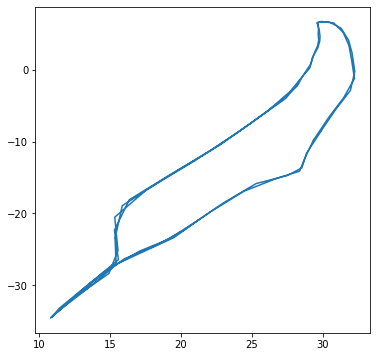

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.plot(layer_output[:,1],layer_output[:,2])
plt.show()

## 5. Reconstrucción de la pelicula

Por último, vamos a reconstruir la película, pero utilizando la salida de la red. Esto sería equivalente a utilizar los modos encontrados, ya que los valores que vemos a la salida de la red estan determinados por los valores en las neuronas de `Latent Space`.

In [ ]:
# Defino una lista donde acumularemos las imagenes
lista_proyeccion = []

# Recorro en el tiempo (en nuestro caso son 95 frames)
for j in range(Y.shape[0]): # recorro los 95 frames

    suma_modos = model.predict(Y[j].reshape((1,numero_pixeles)))
    suma_modos = suma_modos.reshape((dims[1],dims[2]))
    # Por ultimo Transformamos la matriz a valores enteros entre 0 y 255
    # (Esto es lo inveros a lo que hicimos al leer los datos)
    suma_modos = suma_modos + X_medio
    suma_modos = suma_modos * 255
    suma_modos = np.clip(suma_modos, 0, 255)
    suma_modos = suma_modos.astype('uint8')
    lista_proyeccion.append(suma_modos)

Guardamos el nuevo gif reconstruido en nuestra carpeta de trabajo:

In [ ]:
import imageio
dir_gif = root_dir+'proyeccion_autoencoder.gif'
imageio.mimsave(dir_gif, lista_proyeccion)

Podemos observar como quedó nuestra pelicula realizada unicamente con N modos.

In [ ]:
from IPython.display import Image

print('Pelicula generada con ',NUM_MODOS ,'modos')
Image(open(dir_gif,'rb').read())

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# el gif posta
from IPython.display import Image
Image(url='http://materias.df.uba.ar/sdeiaaamdda2020c2/files/2012/07/membranagif.gif')

**Ejercicio:** Compare el desempeño de la descomposición modal realizada con el autoencoder contra el mecanismo de SVD para distintos valores de N (número de modos). Para esto, utilice como métrica el Mean square error (diferencia entre imagen original y reconstruida).

In [ ]:
#sklearn.metrics.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)
Y_pred = np.array(lista_proyeccion)/255 - X_medio
print(Y.shape, Y_pred.shape)
print(Y[0,10], Y_pred[0,0,10])


print(np.sum((Y.flatten() - Y_pred.flatten())**2)/Y.size)

(95, 20040) (95, 167, 120)
-0.2070856 -0.20708559658013137
0.00012727078090147992


In [ ]:
1.1252e-04 # el valor de la loss en la ultima epoch

0.00011252

**El valor de la mean square error calculado como en dos celdas mas arriba deberia dar parecido al valor de la loss en la ultima epoch.  Hay una funcion de numpy que calcula el mse. El mse en SVD tiene que ver con la suma acumulativa (svd truncado).** 

## 6. Extra: Interpretación de los modos 

En este esquema de trabajo es dificil intempretar a que corresponde cada modo. De hehco, al tratarse de modos no lineales, mirando la activación del modo 1 y del modo 2 por separado, no es posible inferir como será la interacción de ambos modos activos al mismo tiempo. Mas aún, una activación de un único modo con intensidad 2, no necesariamente genera una imagen que sea equivalente 2 veces la imgen generada por eso modo con intensidad 1.

Sin embargo, podemos hacer un intento y graficar como se verían las imagenes para cada modo activado por separado.

Para esto será necesario definir el modelo de otra forma, ya que luego vamos a querer definir "a mano" el valor de activación en la capa correspondiente al `latent space`.

**Importante:** No es necesario que comprendan el código a continuación.


In [ ]:
from keras.layers.core import Dense, Activation
from keras.layers import Input
from keras.models import Model

numero_pixeles = Y.shape[1]
NUM_MODOS = 3


# Definimos las capas que del encoder y como se conectan
input_img= Input(shape=(numero_pixeles,))
encoded = Dense(units=64, activation='relu')(input_img)
encoded = Dense(units=32, activation='relu')(encoded)
encoded = Dense(units=16, activation='relu')(encoded)

# Usamos neuronas que pueden tomar valores negativos para la hidden layer.
encoded = Dense(units=NUM_MODOS, activation='linear')(encoded)

# Definimos las capas del decoder
decoder_1 = Dense(units=16, activation='relu')
decoder_2 = Dense(units=32, activation='relu')
decoder_3 = Dense(units=64, activation='relu')
decoder_4 = Dense(units=numero_pixeles, activation='linear')

# Definimos como se conectan las capas del decoder en el autoencoder
decoder_1_output = decoder_1(encoded)
decoder_2_output = decoder_2(decoder_1_output)
decoder_3_output = decoder_3(decoder_2_output)
decoder_4_output = decoder_4(decoder_3_output)

# Preparamos unas capas para el modelo que nos lleve del
# valor de las 3 neuronas del latent space a una imagen (el decoder)
input_modos = Input(shape=(NUM_MODOS,))
modos_1_act = decoder_1(input_modos)
modos_2_act = decoder_2(modos_1_act)
modos_3_act = decoder_3(modos_2_act)
modos_4_act = decoder_4(modos_3_act)


# Definimos el modelo autoencoder y el encoder
autoencoder = Model(input_img, decoder_4_output)
encoder = Model(input_img, encoded)

# Definimos un modelo para inspeccionar los modos
modos_activacion = Model(input_modos, modos_4_act)

autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20040)]           0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                1282624   
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
_________________________________________________________________
dense_12 (Dense)             (None, 16)                64        
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

**Si la cantidad de parametros es lo suficientemente grande (la complejidad es grande) entonces los minimos locales no son tan malos.** 

Compilamos y entrenamos el modelo.

In [ ]:
autoencoder.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')
# training the model and saving metrics in history
history = autoencoder.fit(Y, Y,
          batch_size=16, 
          epochs=500,
          validation_split=0.1,
          verbose=1)

Epoch 1/500
6/6 [==============================] - 0s 23ms/step - loss: 0.0468 - mean_absolute_error: 0.1548 - val_loss: 0.0252 - val_mean_absolute_error: 0.1156
Epoch 2/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0137 - mean_absolute_error: 0.0822 - val_loss: 0.0077 - val_mean_absolute_error: 0.0677
Epoch 3/500
6/6 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0618 - val_loss: 0.0055 - val_mean_absolute_error: 0.0517
Epoch 4/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_absolute_error: 0.0484 - val_loss: 0.0047 - val_mean_absolute_error: 0.0451
Epoch 5/500
6/6 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_absolute_error: 0.0450 - val_loss: 0.0044 - val_mean_absolute_error: 0.0425
Epoch 6/500
6/6 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_absolute_error: 0.0427 - val_loss: 0.0041 - val_mean_absolute_error: 0.0417
Epoch 7/500
6/6 [================

Graficamos la activación de los modos para las imágenes del dataset en fucnión del tiempo.

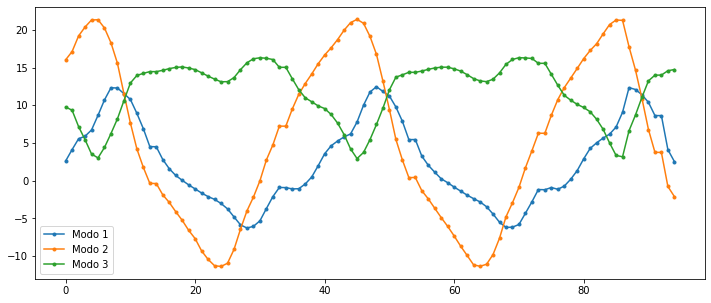

In [ ]:
# Usamo' un modelo que nos lleva de los datos a la capa intermedia (latent space)
layer_output = encoder(Y) # layer_output es una funcion

plt.figure(figsize=(12,5))
plt.subplot(1,1,1)
plt.plot(layer_output[:,0],'.-',label='Modo 1')
plt.plot(layer_output[:,1],'.-',label='Modo 2')
plt.plot(layer_output[:,2],'.-',label='Modo 3')
plt.legend()

Observe el valor de activación de cada una de las 3 neuronas (eje y) en la serie temporal graficada en la celda anterior. Tome estos valores como una referencia de que puede considerar como valor de activación para cada uno de los modos.


Por último, vamos a imponerle valores a la capa intermedia del modelo y ver cual es la imagen a la salida.

Recuerden algo importante: en este esquema no hay una jerarquía de importancia entre los modos. 

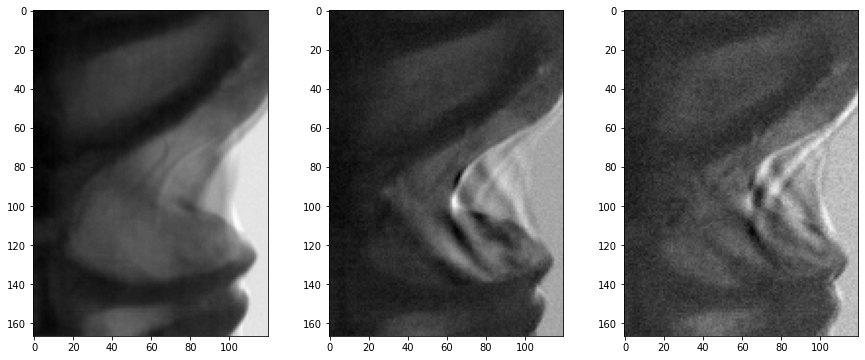

In [ ]:
# Elegimos el valor de las neuronas en la capa intermedia
# Y guardamos la salida del autoencoder para cada uno de los modos
modo_1 = modos_activacion.predict(np.asarray([0,0,10]).reshape(1,3)) # el 10 esta puesto a mano
modo_2 = modos_activacion.predict(np.asarray([0,10,0]).reshape(1,3))
modo_3 = modos_activacion.predict(np.asarray([10,0,0]).reshape(1,3))


# Graficamos
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(np.reshape(modo_1,(dims[1],dims[2])),cmap='gray',vmin=np.min(modo_1),vmax=np.max(modo_1))
plt.subplot(1,3,2)
plt.imshow(np.reshape(modo_2,(dims[1],dims[2])),cmap='gray',vmin=np.min(modo_2),vmax=np.max(modo_2))
plt.subplot(1,3,3)
plt.imshow(np.reshape(modo_3,(dims[1],dims[2])),cmap='gray',vmin=np.min(modo_3),vmax=np.max(modo_3))

plt.show()

Como verán, es muy dificil interpretar los modos. Esto evidencia un trade-off bastante universal: una reducción de dimensionalidad mas efectiva (no lineal) conlleva una perdida en de intepretabilidad de los modos encontrados.

Con el algoritmo uno pierde interpretabilidad. Si, tengo la forma analitica de los modos, pues tengo la forma analitica de cada neurona. Pero anda a analizar esa funcion. Son muchas funciones no lineales superpuestas. La no linealidad no te deja pensar en superposicion de modos. Si prendo un modo 1 solo, prendo otro modo 2 solo, prender los dos modos juntos no es la suma de prender el modo 1 solo y el modo 2 solo. Metes dos modos prendidos y no sabes que pasa. Hay que estudiar todo los modos completos. O algo asi. 